In [8]:
!pip install imbalanced-learn
!pip install shap

In [9]:
#Libraries

import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from scipy.stats import uniform, randint

#smote
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

#Grid search
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [10]:
df = pd.read_excel(r'C:\Users\Jose Chua\OneDrive\Python\School Snek Work\831\Team_Project\cleaned2.xlsx')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 63 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   duration_of_dcp                              3122 non-null   int64  
 1   DCP_drop_status                              3122 non-null   int64  
 2   age_at_activation                            3122 non-null   int64  
 3   dependents_at_activation                     3122 non-null   int64  
 4   number_in_household_at_activation            3122 non-null   int64  
 5   asset_amount_owed_at_activation              3122 non-null   int64  
 6   asset_value_at_activation                    3122 non-null   int64  
 7   monthly_income_at_activation                 3122 non-null   float64
 8   monthly_expenses_at_activation               3122 non-null   float64
 9   DCP_debt_at_activation                       3122 non-null   int64  
 10  

In [12]:
df['age_df_debt']=df['age_at_activation']*df['DCP_debt_at_activation']
df['duration_df_debt_balance'] = df['duration_of_dcp'] * df['DCP_debt_balance_at_activation']
df['household_dependency_ratio'] = df['number_in_household_at_activation'] / df['age_at_activation']

In [13]:

columns_to_drop = [
    'DCP_activation_date_year', 'DCP_activation_date_month', 'DCP_activation_date_day',
    'DCP_start_date_year', 'DCP_start_date_month', 'DCP_start_date_day',
    'DCP_drop_date_year', 'DCP_drop_date_month', 'DCP_drop_date_day',
    'activation_month_sin', 'activation_month_cos', 'activation_day_sin', 'activation_day_cos',
    'start_month_sin', 'start_month_cos', 'start_day_sin', 'start_day_cos',
    'drop_month_sin', 'drop_month_cos', 'drop_day_sin', 'drop_day_cos'
]

# Drop the columns
df.drop(columns=columns_to_drop, inplace=True)

# Verify columns are dropped
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 45 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   duration_of_dcp                              3122 non-null   int64  
 1   DCP_drop_status                              3122 non-null   int64  
 2   age_at_activation                            3122 non-null   int64  
 3   dependents_at_activation                     3122 non-null   int64  
 4   number_in_household_at_activation            3122 non-null   int64  
 5   asset_amount_owed_at_activation              3122 non-null   int64  
 6   asset_value_at_activation                    3122 non-null   int64  
 7   monthly_income_at_activation                 3122 non-null   float64
 8   monthly_expenses_at_activation               3122 non-null   float64
 9   DCP_debt_at_activation                       3122 non-null   int64  
 10  

In [14]:
inf_columns = ['duration_of_dcp','asset_amount_owed_at_activation','asset_value_at_activation','asset_net_woth']
df.drop(columns=inf_columns, inplace=True)

In [15]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [16]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [17]:
#XGBoost

X = df.drop(columns=['DCP_drop_status'])
y = df['DCP_drop_status']

#training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

#evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

[[299  61]
 [ 59 206]]
Accuracy: 0.81
Precision: 0.77
Recall: 0.78
F1 Score: 0.77
AUC-ROC: 0.89


In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       360
           1       0.77      0.78      0.77       265

    accuracy                           0.81       625
   macro avg       0.80      0.80      0.80       625
weighted avg       0.81      0.81      0.81       625



<Figure size 1500x1000 with 0 Axes>

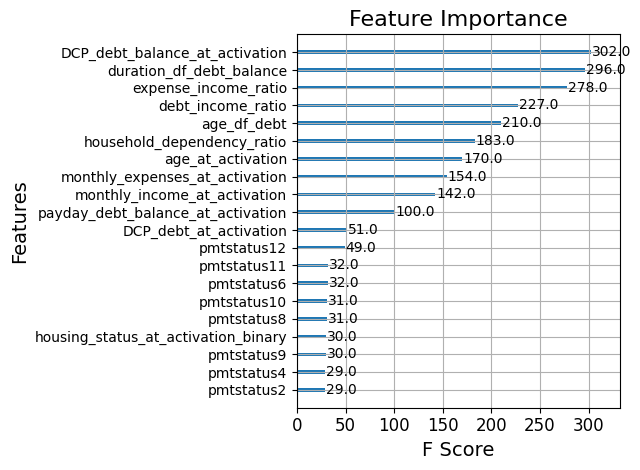

In [19]:
#feature importance

plt.figure(figsize=(15, 10))  # Adjust the size (width, height)

# Plot the feature importance
plot_importance(xgb_model, max_num_features=20, importance_type='weight', xlabel="F score")

# Adjust font size for better readability
plt.title("Feature Importance", fontsize=16)
plt.xlabel("F Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()  # Automatically adjust subplots to fit the figure area
plt.show()

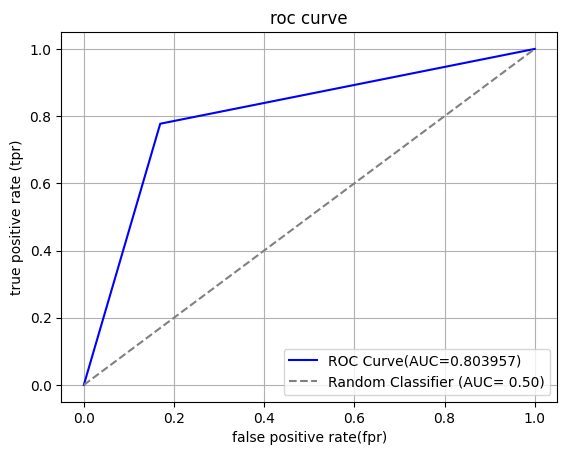

In [20]:
#auc curve

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = roc_auc_score(y_test,y_pred)

plt.figure()
plt.plot(fpr,tpr,color='blue',label=f'ROC Curve(AUC={roc_auc:2f})')
plt.plot([0,1],[0,1],color='gray',linestyle = '--',label='Random Classifier (AUC= 0.50)')
plt.xlabel('false positive rate(fpr)')
plt.ylabel('true positive rate (tpr)')
plt.title('roc curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [21]:
#checking balance 
print(y.value_counts(normalize=True))  # Proportion of each class

DCP_drop_status
0    0.605701
1    0.394299
Name: proportion, dtype: float64


In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define the XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],           # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],       # Step size shrinkage
    'max_depth': [3, 5, 7],                  # Maximum tree depth
    'subsample': [0.6, 0.8, 1.0],            # Fraction of samples for training
    'colsample_bytree': [0.6, 0.8, 1.0],     # Fraction of features for training
    'gamma': [0, 1, 5],                      # Minimum loss reduction for split
    'reg_alpha': [0, 1, 10],                 # L1 regularization
    'reg_lambda': [1, 10, 100]               # L2 regularization
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',  # Use AUC-ROC as the metric
    cv=3,               # 3-fold cross-validation
    verbose=2,
    n_jobs=-1           # Use all available processors for parallelism
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score (AUC-ROC):", grid_search.best_score_)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]
y_pred = best_xgb_model.predict(X_test)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Calculate AUC-ROC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC for Test Data: {auc:.2f}")

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits


c:\Users\Jose Chua\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 19683.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Jose Chua\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Jose Chua\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\Jose Chua\AppData\Local\Programs\Python\Python31

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Best Cross-Validation Score (AUC-ROC): 0.8982818062702549

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85       360
           1       0.79      0.84      0.81       265

    accuracy                           0.84       625
   macro avg       0.83      0.84      0.83       625
weighted avg       0.84      0.84      0.84       625

AUC-ROC for Test Data: 0.91


c:\Users\Jose Chua\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [0.87846462 0.87700619 0.87547898 ... 0.86749762 0.86955523 0.87213463]
  warnings.warn(
c:\Users\Jose Chua\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:23:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [23]:
# USE Variance Inflation Factor (VIF) to test multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                        Feature         VIF
0                             age_at_activation    6.352482
1                      dependents_at_activation    2.607247
2             number_in_household_at_activation   16.168696
3                  monthly_income_at_activation   58.143787
4                monthly_expenses_at_activation   56.645070
5                        DCP_debt_at_activation   12.147551
6                DCP_debt_balance_at_activation    4.077913
7          has_payday_debt_on_DCP_at_activation    1.991733
8             payday_debt_balance_at_activation    1.849407
9                                    pmtstatus1    1.654299
10                                   pmtstatus2    2.431216
11                                   pmtstatus3    2.968645
12                                   pmtstatus4    3.580547
13                                   pmtstatus5    4.442614
14                                   pmtstatus6    5.019890
15                                   pmt

In [24]:
with pd.option_context('display.max_rows', None):
    print(vif_data)

                                        Feature         VIF
0                             age_at_activation    6.352482
1                      dependents_at_activation    2.607247
2             number_in_household_at_activation   16.168696
3                  monthly_income_at_activation   58.143787
4                monthly_expenses_at_activation   56.645070
5                        DCP_debt_at_activation   12.147551
6                DCP_debt_balance_at_activation    4.077913
7          has_payday_debt_on_DCP_at_activation    1.991733
8             payday_debt_balance_at_activation    1.849407
9                                    pmtstatus1    1.654299
10                                   pmtstatus2    2.431216
11                                   pmtstatus3    2.968645
12                                   pmtstatus4    3.580547
13                                   pmtstatus5    4.442614
14                                   pmtstatus6    5.019890
15                                   pmt

In [25]:
# Get predicted probabilities for each class
y_proba = xgb_model.predict_proba(X_test)  # Probabilities for classes 0 and 1

# Extract probabilities for class 1
y_class_1_proba = y_proba[:, 1]

# Correlate feature values with predictions for class 1
correlation_with_class_1 = pd.DataFrame({
    'Feature': X_test.columns,
    'Correlation with Class 1': [X_test[feature].corr(pd.Series(y_class_1_proba)) for feature in X_test.columns]
}).sort_values(by='Correlation with Class 1', ascending=False)

print("Feature Correlations with Class 1 Predictions:")
print(correlation_with_class_1)

Feature Correlations with Class 1 Predictions:
                                        Feature  Correlation with Class 1
36                            debt_income_ratio                  0.185211
37                                  age_df_debt                  0.120898
31                             emp_type_Retired                  0.116841
35                         expense_income_ratio                  0.105610
38                     duration_df_debt_balance                  0.103058
6                DCP_debt_balance_at_activation                  0.099347
21                                gender_Female                  0.082428
5                        DCP_debt_at_activation                  0.077838
7          has_payday_debt_on_DCP_at_activation                  0.070356
24  marital status_Common Law/Domestic Partners                  0.068243
20                                  pmtstatus12                  0.064304
18                                  pmtstatus10                  

In [26]:
# Get predicted probabilities for each class
y_proba = xgb_model.predict_proba(X_test)  # Probabilities for classes 0 and 1

# Extract probabilities for class 1
y_class_1_proba = y_proba[:, 1]

# Initialize an empty list to store correlations
correlation_data = []

# Compute correlation between each feature and class 1 probabilities
for feature in X_test.columns:
    try:
        correlation = X_test[feature].corr(pd.Series(y_class_1_proba))
        correlation_data.append({'Feature': feature, 'Correlation with Class 1': correlation})
    except Exception as e:
        print(f"Error calculating correlation for feature {feature}: {e}")

# Convert to DataFrame
correlation_with_class_1 = pd.DataFrame(correlation_data)

# Add absolute correlation values
correlation_with_class_1['Absolute Correlation'] = correlation_with_class_1['Correlation with Class 1'].abs()

# Rank features based on absolute correlation (descending order)
correlation_with_class_1['Rank'] = correlation_with_class_1['Absolute Correlation'].rank(ascending=False)

# Sort the DataFrame by absolute correlation
correlation_with_class_1 = correlation_with_class_1.sort_values(by='Absolute Correlation', ascending=False)

# Display the ranked correlations
print("Feature Correlations with Class 1 Predictions (Ranked):")
print(correlation_with_class_1)


Feature Correlations with Class 1 Predictions (Ranked):
                                        Feature  Correlation with Class 1  \
36                            debt_income_ratio                  0.185211   
32                          emp_type_Unemployed                 -0.143295   
37                                  age_df_debt                  0.120898   
9                                    pmtstatus1                 -0.116845   
31                             emp_type_Retired                  0.116841   
35                         expense_income_ratio                  0.105610   
38                     duration_df_debt_balance                  0.103058   
6                DCP_debt_balance_at_activation                  0.099347   
23                    gender_Other/Not Reported                 -0.096118   
12                                   pmtstatus4                 -0.093096   
26                       marital status_Married                 -0.089930   
21                  

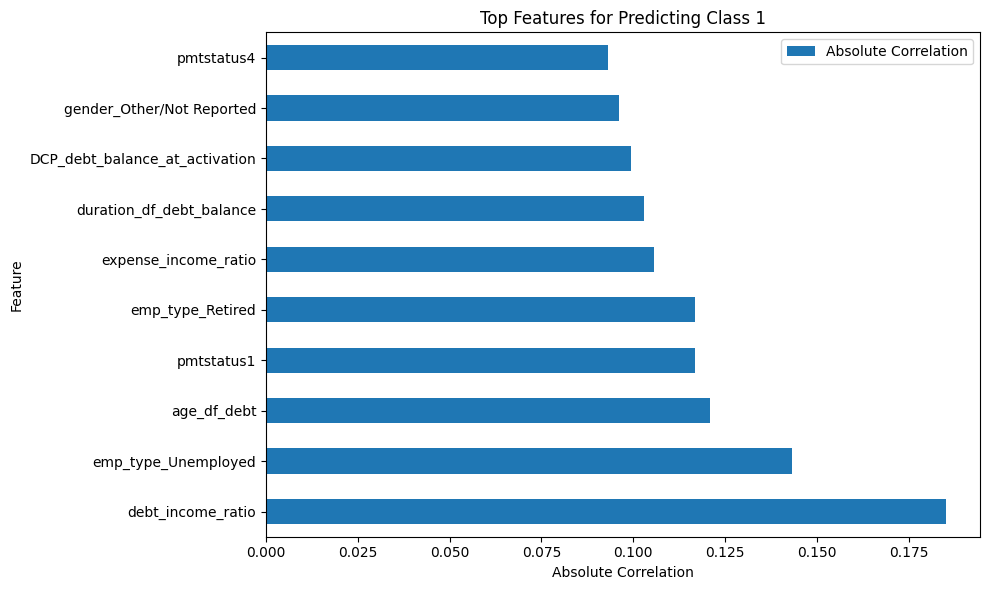

In [27]:
correlation_with_class_1.head(10).plot(kind='barh', x='Feature', y='Absolute Correlation', figsize=(10, 6))
plt.title('Top Features for Predicting Class 1')
plt.xlabel('Absolute Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

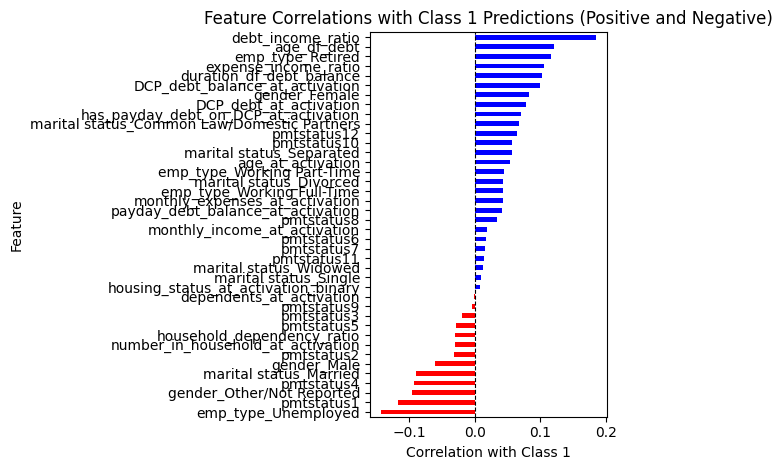

In [30]:
# Sort the DataFrame by correlation values (descending order for clarity)
correlation_with_class_1 = correlation_with_class_1.sort_values(by='Correlation with Class 1', ascending=True)

# Plot the correlation values
plt.figure(figsize=(10, 6))
correlation_with_class_1.plot(
    kind='barh', 
    x='Feature', 
    y='Correlation with Class 1', 
    color=correlation_with_class_1['Correlation with Class 1'].apply(lambda x: 'red' if x < 0 else 'blue'),
    legend=False
)

# Add title, labels, and a vertical line at 0
plt.title('Feature Correlations with Class 1 Predictions (Positive and Negative)')
plt.xlabel('Correlation with Class 1')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Vertical line for zero correlation
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

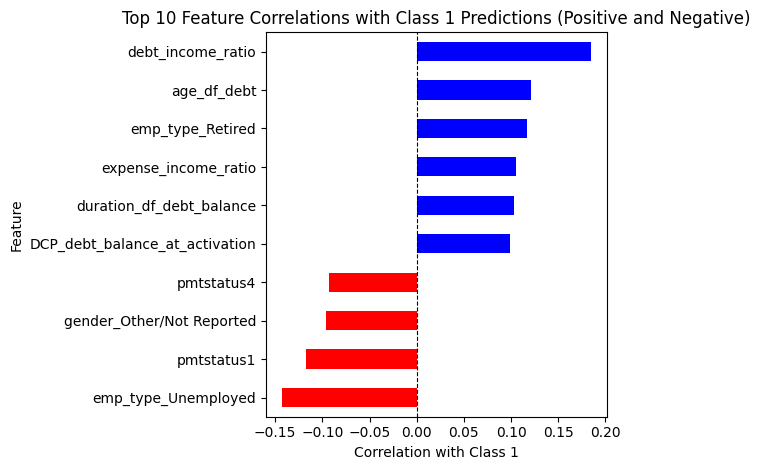

In [31]:
# Sort by absolute correlation and select the top 10 features
top_10_features = correlation_with_class_1.nlargest(10, 'Absolute Correlation')

# Sort the top 10 by actual correlation values to properly display negatives and positives
top_10_features = top_10_features.sort_values(by='Correlation with Class 1', ascending=True)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
top_10_features.plot(
    kind='barh',
    x='Feature',
    y='Correlation with Class 1',
    color=top_10_features['Correlation with Class 1'].apply(lambda x: 'red' if x < 0 else 'blue'),
    legend=False
)

# Add title, labels, and a vertical line at 0
plt.title('Top 10 Feature Correlations with Class 1 Predictions (Positive and Negative)')
plt.xlabel('Correlation with Class 1')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Vertical line for zero correlation
plt.tight_layout()

# Show the plot
plt.show()